In [15]:
import torch
from trainer import *
from torch.utils.data import DataLoader
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from models.CNN import *

# Предобработка данных

In [16]:
compr_data_path = r"C:\Users\Biomechanics\Documents\ddd\data\PDMS\Compression_pdms.csv"
tensl_data_path = r"C:\Users\Biomechanics\Documents\ddd\data\PDMS\Tensile_pdms.csv"
shear_data_path = r"C:\Users\Biomechanics\Documents\ddd\data\PDMS\Shear_pdms.csv"
experiments_path = [compr_data_path, tensl_data_path, shear_data_path]

In [17]:
data_frames = [pd.read_csv(file, header=None) for file in experiments_path]
df = pd.concat(data_frames, ignore_index=True)
thinned_data_frames = []
num_points = 50

sampled_df_list = []

for df in data_frames:
    indices = np.linspace(0, len(df) - 1, num_points, dtype=int)
    df[1] = df[1] / 10**3
    sampled_df = pd.DataFrame(df.iloc[indices].copy())
    # print(type(sampled_df))
    sampled_df_list.append(sampled_df)
    # thinned_df = df.iloc[::len(df) // 20, :]  # Выбор каждого 45-го значения
    # thinned_data_frames.append(thinned_df)
data_frames = sampled_df_list

# sampled_df_list[0]


In [18]:
I1_tc = lambda lam: lam ** 2 + 2.0 / lam
I2_tc = lambda lam: 2.0 * lam + 1 / lam ** 2
I1_s = lambda gam: gam ** 2 + 3.0
F_tc = lambda lam: ([lam, 0, 0], [0, lam - 0.5, 0], [0, 0, lam - 0.5])
F_s = lambda gam: ([1., gam, 0], [0, 1., 0], [0, 0, 1.])


In [19]:
mechanical_variables = {
    "I1": [I1_tc, I1_s],
    "I2": [I2_tc, I1_s],
    "F": [F_tc, F_s],
    # "exp_type": [(lambda x: 1), (lambda x: 0)] # 1 - torsion&compression, 0 - shear
    # "torsion_compression": (lambda x: 1)
}

# calculate I1, I2, F from lambda (torsion&compression and shear)
for variable in mechanical_variables.keys():
    func_calc = mechanical_variables.get(variable)

    data_frames[0][variable] = data_frames[0][0].apply(func_calc[0])
    data_frames[1][variable] = data_frames[1][0].apply(func_calc[0])
    data_frames[2][variable]  = data_frames[2][0].apply(func_calc[1])


In [20]:
experiments = ['Compression', 'Tensile', 'Shear']
combined_data = pd.concat([df.assign(Experiment=exp) for df, exp in zip(data_frames, experiments)]).reset_index(drop=True, inplace=False)


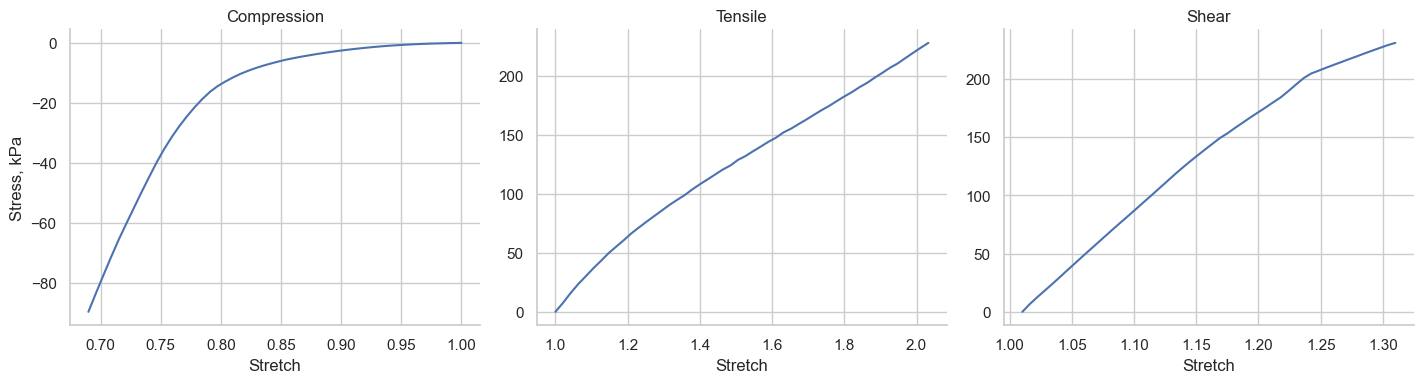

In [21]:
sns.set(style="whitegrid")
g = sns.relplot(
    data=combined_data,
    x=0, y=1, col='Experiment', kind='line', height=4, aspect=1.2, facet_kws={'sharey': False, 'sharex': False}
)

# Update axis labels
g.set_axis_labels("Stretch", "Stress, kPa")
g.set_titles("{col_name}")
plt.show()

In [22]:
combined_data

,0,1,I1,I2,F,Experiment
0,0.689936,-89.636249,3.374831,3.480661,"([0.689936, 0, 0], [0, 0.189936, 0], [0, 0, 0....",Compression
1,0.696069,-83.561705,3.357790,3.456069,"([0.6960692, 0, 0], [0, 0.19606920000000005, 0...",Compression
2,0.702543,-77.319573,3.340368,3.431155,"([0.702543, 0, 0], [0, 0.20254300000000003, 0]...",Compression
3,0.708676,-71.499856,3.324385,3.408504,"([0.7086762, 0, 0], [0, 0.20867619999999998, 0...",Compression
4,0.715150,-65.572652,3.308056,3.385565,"([0.71515, 0, 0], [0, 0.21514999999999995, 0],...",Compression
...,...,...,...,...,...,...
145,1.285386,221.586360,4.652217,4.652217,"([1.0, 1.2853858, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
146,1.291392,223.891680,4.667693,4.667693,"([1.0, 1.2913918, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
147,1.297698,226.308070,4.684020,4.684020,"([1.0, 1.2976981, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
148,1.303704,228.545000,4.699644,4.699644,"([1.0, 1.3037041, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear


In [23]:
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
import copy 

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # self.features = [dataframe[0],dataframe[2], dataframe[3], dataframe[4], dataframe[5]]
        # self.targets  = dataframe[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = copy.deepcopy([*self.data.iloc[idx]])
        target = features.pop(1)

        return features, target

    def to_tensor(self):
        for column in self.data.columns[:-1]:
            self.data[column] = self.data[column].apply(
                lambda x: torch.tensor(x, dtype=torch.float32)).copy()


In [28]:
train_dataset = CustomDataset(combined_data[:30])
test_dataset = CustomDataset(combined_data)
# f, t = dataset[0]
# lam, i1, i2, F, exp_type = f
# exp_type

In [29]:
train_dataset.to_tensor()
test_dataset.to_tensor()

train_data_loader = DataLoader(
                        train_dataset,
                        shuffle=True,
                        # num_workers=1,
                        pin_memory=False
)
test_data_loader = DataLoader(
                        test_dataset,
                        shuffle=False,
                        # num_workers=1,
                        pin_memory=False
)

C:\Users\Biomechanics\AppData\Local\Temp\ipykernel_11904\2128893158.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[column] = self.data[column].apply(


 0.00 * (I1 - 3) \\               + 0.00 * (e^{  0.13 * (I1 - 3)} - 1)\\               - 0.10 * ln(1 - 1.18 * (I1 - 3)) \\               + 4.83 * (I1 - 3) ^ 2 \\               + 2.68 * (e^{  1.92 * (I1 - 3) ^ 2} - 1)\\               - 0.00 * ln(1 - 0.03 * (I1 - 3) ^ 2) \\                               + 0.00 * (I2 - 3) \\               + 0.97 * (e^{  0.76 * (I2 - 3))} - 1)\\               - 2.24* ln(1 - 1.12 *  (I2 - 3)) \\               + 0.67 * (I2 - 3) ^ 2 \\               + 2.43 * (e^{  2.03 *(I2 - 3) ^ 2)} - 1)\\               - 0.82* ln(1 - 1.00 * (I2 - 3) ^ 2)\\
0.0


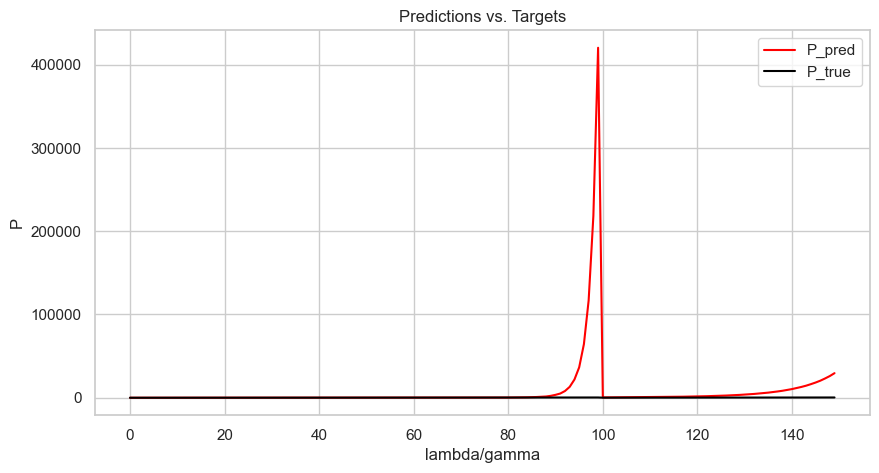

In [30]:
best_model_path = r"pretrained_models\PDMS_6term\20240516_213016_876.pth"
trained_model = StrainEnergyCANN_C()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # if features[-1] == 1.5:
    vpredictions.append(trained_model(features).detach().numpy())
    vtargets.append(target.detach().numpy())
print(trained_model.get_potential())
print(r2_score_own(vtargets, vpredictions))
plt.figure(figsize=(10, 5))
plt.plot(vpredictions, label='P_pred', color='red')
plt.plot(vtargets, label='P_true', color='black')
plt.xlabel('lambda/gamma')
plt.ylabel('P')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()

In [ ]:
best_model_path = r"pretrained_models\PDMS_test\20240516_203453_1000.pth"
trained_model = StrainEnergyCANN_polinomial3()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # if features[-1] == 1.5:
    vpredictions.append(trained_model(features).detach().numpy())
    vtargets.append(target.detach().numpy())
print(trained_model.get_potential())
print(r2_score_own(vtargets, vpredictions))
plt.figure(figsize=(10, 5))
plt.plot(vpredictions, label='P_pred', color='red')
plt.plot(vtargets, label='P_true', color='black')
plt.xlabel('lambda/gamma')
plt.ylabel('P')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()

In [ ]:
best_model_path = r"pretrained_models\PDMS_test\20240516_204414_1600.pth"
trained_model = StrainEnergyCANN_polinomial3()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # if features[-1] == 1.5:
    vpredictions.append(trained_model(features).detach().numpy())
    vtargets.append(target.detach().numpy())
print(trained_model.get_potential())
print(r2_score_own(vtargets, vpredictions))
plt.figure(figsize=(10, 5))
plt.plot(vpredictions, label='P_pred', color='red')
plt.plot(vtargets, label='P_true', color='black')
plt.xlabel('lambda/gamma')
plt.ylabel('P')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()

In [ ]:
# test_train = Trainer(
    plot_valid=False,
    epochs=5000,
    experiment_name="PDMS_6term",
    l2_reg_coeff=0.01,
    learning_rate=0.001,
    checkpoint=None,
    model=StrainEnergyCANN_C
)

trained_model = test_train.train(train_data_loader, test_data_loader, weighting_data=False)
# trained_model = StrainEnergyCANN_C()
# trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    # if features[-1] == 1.5:
    vpredictions.append(trained_model(features).detach().numpy())
    vtargets.append(target.detach().numpy())
print(trained_model.get_potential())
print(r2_score_own(vtargets, vpredictions))
plt.figure(figsize=(10, 5))
plt.plot(vpredictions, label='P_pred', color='red')
plt.plot(vtargets, label='P_true', color='black')
plt.xlabel('lambda/gamma')
plt.ylabel('P')
plt.title('Predictions vs. Targets')
plt.legend()
plt.show()

In [ ]:
# main()